# Fake news detector

On this notebook we are going to take best model from the __[Final modelling notebook](https://github.com/pipe11/TFM_fake_news_detector/blob/master/models/11_final_notebook_models_explained.ipynb)__, and load it. It resulted that the best model is XGBOOST, but we are considering 2 models:
1. XGBOOST without features extracted from TFIDF vectorizer
2. XGBOOST with features extracted from TFIDF vectorizer

At first, we are going to consider the easy approach with the first model and later on we will try a predictor with the second model.

## INDEX

[1. Functions](#1.-Functions)

[2.Extract news with url](#2.-Extract-news-with-url)

[3. First model predictor](#3.-First-model-predictor)

4. Second model predictor

## 1. Functions

We need a function to extrat features from the New's text content and headline that we are going to classify as fake or real. For this case we are going to use the function `get_news_features()` from the __[Final feature extraction notebook](https://github.com/pipe11/TFM_fake_news_detector/blob/master/feature_extraction/06_Final_notebook_feature_extraction_explained.ipynb)__. 

Also we are using the following function `get_nsyllables()` to extract the syllables from the text:

### `get_nsyllables()`

In [121]:
def get_nsyllables(text):
    from syltippy import syllabize
    
    text = text.replace(r"*URL*", "url")
    text = re.sub(r'\d+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r'[^ \nA-Za-z0-9ÁÉÍÓÚÑáéíóúñ/]+', '', text)
    
    n_syllables = len(syllabize(text)[0])
    
    return n_syllables

### `get_news_features()`

We are not including number of words, sentences, quotes, and syllables, only ratios.

In [155]:
%%time

import pandas as pd
import nltk
import spacy
import re
from nltk import FreqDist
from lexical_diversity import lex_div as ld

def get_news_features(headline, text):
    
    nlp = spacy.load('es_core_news_lg')

    ## headline ##
    headline = re.sub(r"http\S+", "", headline)
    headline = re.sub(r"http", "", headline)
    headline = re.sub(r"@\S+", "", headline)
    headline = re.sub("\n", " ", headline)
    headline = re.sub(r"(?<!\n)\n(?!\n)", " ", headline)
    headline = headline.replace(r"*NUMBER*", "número")
    headline = headline.replace(r"*PHONE*", "número")
    headline = headline.replace(r"*EMAIL*", "email")
    headline = headline.replace(r"*URL*", "url")
    headline_new = headline.lower()
    doc_h = nlp(headline_new)

    list_tokens_h = []
    list_tags_h = []

    for sentence_h in doc_h.sents:
        for token in sentence_h:
            list_tokens_h.append(token.text)

    fdist_h = FreqDist(list_tokens_h)
    syllables_h = get_nsyllables(headline)
    words_h = len(list_tokens_h)

    # headline complexity features
    avg_word_size_h = round(sum(len(word) for word in list_tokens_h) / words_h, 2)
    avg_syllables_word_h = round(syllables_h / words_h, 2)
    unique_words_h = round((len(fdist_h.hapaxes()) / words_h) * 100, 2)
    mltd_h = round(ld.mtld(list_tokens_h), 2)
    ttr_h = round(ld.ttr(list_tokens_h) * 100, 2)

    ## text content##     
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"http", "", text)
    text = re.sub("\n", " ", text)
    text = text.replace(r"*NUMBER*", "número")
    text = text.replace(r"*PHONE*", "número")
    text = text.replace(r"*EMAIL*", "email")
    text = text.replace(r"*URL*", "url")

    # to later calculate upper case letters ratio
    alph = list(filter(str.isalpha, text))
    text_lower = text.lower()
    doc = nlp(text_lower)

    list_tokens = []
    list_pos = []
    list_tag = []
    list_entities = []
    sents = 0

    for entity in doc.ents:
        list_entities.append(entity.label_)

    for sentence in doc.sents:
        sents += 1
        for token in sentence:
            list_tokens.append(token.text)
            list_pos.append(token.pos_)
            list_tag.append(token.tag_)

    # Calculate entities, pos, tag, freq, syllables, words and quotes
    entities = len(list_entities)
    n_pos = nltk.Counter(list_pos)
    n_tag = nltk.Counter(list_tag)
    fdist = FreqDist(list_tokens)
    syllables = get_nsyllables(text)
    words = len(list_tokens)
    quotes = n_tag['PUNCT__PunctType=Quot']

    # complexity features
    avg_word_sentence = round(words / sents, 2)
    avg_word_size = round(sum(len(word) for word in list_tokens) / words, 2)
    avg_syllables_word = round(syllables / words, 2)
    unique_words = round((len(fdist.hapaxes()) / words) * 100, 2)
    ttr = round(ld.ttr(list_tokens) * 100, 2)

    # readability spanish test
    huerta_score = round(206.84 - (60 * avg_syllables_word) - (1.02 * avg_word_sentence), 2)
    szigriszt_score = round(206.835 - ((62.3 * syllables) / words) - (words / sents), 2)

    # stylometric features
    mltd = round(ld.mtld(list_tokens), 2)
    upper_case_ratio = round(sum(map(str.isupper, alph)) / len(alph) * 100, 2)
    entity_ratio = round((entities / words) * 100, 2)
    quotes_ratio = round((quotes / words) * 100, 2)
    propn_ratio = round((n_pos['PROPN'] / words) * 100 , 2)
    noun_ratio = round((n_pos['NOUN'] / words) * 100, 2) 
    pron_ratio = round((n_pos['PRON'] / words) * 100, 2)
    adp_ratio = round((n_pos['ADP'] / words) * 100, 2)
    det_ratio = round((n_pos['DET'] / words) * 100, 2)
    punct_ratio = round((n_pos['PUNCT'] / words) * 100, 2)
    verb_ratio = round((n_pos['VERB'] / words) * 100, 2)
    adv_ratio = round((n_pos['ADV'] / words) * 100, 2)
    sym_ratio = round((n_tag['SYM'] / words) * 100, 2)

    # create df_features
    df_features = pd.DataFrame({'words_h': words_h, 'word_size_h': [avg_word_size_h],'avg_syllables_word_h': [avg_syllables_word_h],
                                'unique_words_h': [unique_words_h], 'ttr_h': ttr_h, 'mltd_h': [mltd_h], 'sents': sents, 'words': words,
                                'avg_words_sent': [avg_word_sentence], 'avg_word_size': [avg_word_size], 
                                'avg_syllables_word': avg_syllables_word, 'unique_words': [unique_words], 
                                'ttr': [ttr], 'huerta_score': [huerta_score], 'szigriszt_score': [szigriszt_score],
                                'mltd': [mltd], 'upper_case_ratio': [upper_case_ratio], 'entity_ratio': [entity_ratio],
                                'quotes': quotes, 'quotes_ratio': [quotes_ratio], 'propn_ratio': [propn_ratio], 
                                'noun_ratio': [noun_ratio], 'pron_ratio': [pron_ratio], 'adp_ratio': [adp_ratio],
                                'det_ratio': [det_ratio], 'punct_ratio': [punct_ratio], 'verb_ratio': [verb_ratio],
                                'adv_ratio': [adv_ratio], 'sym_ratio': [sym_ratio]})
    
    return df_features

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 32.9 µs


### Check if it works

In [4]:
headline = input('Insert news headline:')
text = input('Insert news content:')

get_news_features(text, headline)

Insert news headline:Más de 2.000 profesores de Madrid tendrán que repetir el test tras dar positivo por Covid en la primera prueba
Insert news content:Entre 2.000 y 2.500 positivos por Covid, esas son las cifras que arrojan los aproximadamente 67.000 test realizados por la Comunidad de Madrid a los profesores de la región durante esta pasada semana. Así lo ha apuntado este domingo el consejero de Educación, Enrique Ossorio, que ha hecho balance de esas pruebas este domingo durante su visita al albergue juvenil de Los Batanes, en la localidad de Rascafría.  "Queríamos que antes de que empezara el curso todos los profesores se hicieran test serológicos para dar seguridad a todas la sociedad", ha remarcado el consejero, que ha afirmado que Madrid "no ha escatimado" en la realización de estas pruebas a las que han acudido el 90% de los docentes de la región. Unas pruebas que se han saldado con un porcentaje de positivos entre los docentes superior al 3,5%.  Ahora esos profesores cuya prue

,words_h,avg_word_size_h,avg_syllables_word,unique_words_h,mltd_h,sents,words,avg_word_sentence,avg_word_size,unique_words,...,quotes_ratio,propn_ratio,noun_ratio,pron_ratio,adp_ratio,det_ratio,punct_ratio,verb_ratio,adv_ratio,sym_ratio
0,592,4.53,1.65,33.28,68.8,1,20,20.0,4.55,90.0,...,0.0,10.0,15.0,0.0,25.0,10.0,0.0,15.0,5.0,0.0


## 2. Extract news with url

### ¿How to extract the headline and New's content directly with and url?

This is possible with __[Newspaper3k: Article scraping & curation](https://github.com/codelucas/newspaper)__ library for python that extracts the headline and the new's content from any newspaper

In [6]:
!pip3 install newspaper3k

    100% |████████████████████████████████| 215kB 1.2MB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 2.0MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/64/c2/b80047c7ac2478f9501676c988a5411ed5572f35d1beff9cae07d321512c/PyYAML-5.3.1.tar.gz
    100% |████████████████████████████████| 122kB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 7.4MB 180kB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 2.4MB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/45/1e/0c169c6a5381e241ba7404532c16a21d86ab872c9bed8bdcd4c423954103/requests-2.24.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/30/bf/92385b4262178ca22b34f82e0e09c2922eb351fe39f3cc7b8ba9ea555b41/Pillow-7.2.0-cp36-cp36m-manylinux1_x86_64.whl
    100% |███████████

In [60]:
from newspaper import Article

url = input('Insert url: ')

article = Article(url)
article.download()
article.parse()

if article.authors == []:
    print(article.title, '\n\n', article.text)
    
else:
    print(article.authors, '\n\n', article.title, '\n\n', article.text)

Insert url: https://elpais.com/ideas/2020-09-05/educacion-como-reparar-los-destrozos.html
['J. A. Aunión', 'José Manuel Romero'] 

 Educación: cómo reparar los destrozos 

 La epidemia más devastadora de los últimos 100 años ha destapado las insuficiencias del sistema sanitario y las debilidades del sistema educativo en España. Tres meses de confinamiento con los servicios públicos de salud desbordados como nunca (más de 100.000 ingresos hospitalarios en menos de 100 días; más de 45.000 fallecidos en ese tiempo por la Covid-19) y la educación metida en una pausa incierta (8,2 millones de alumnos y 712.000 profesores encerrados en sus casas a mitad de curso) han agrandado la grieta que sufre desde hace tiempo el Estado de bienestar.

Una comisión del Congreso de los Diputados estudió durante dos meses cómo reparar tanto destrozo. Casi todos los expertos defendieron la necesidad de reformar sectores públicos estratégicos, antes golpeados por los recortes de la última crisis económica y a

We can't do anything if we use this library to extract premium news from newspaper, this will take only a short portion of the news. So later on we need to specify this on the app.

Now lets use this library to extract headline and text features:

In [66]:
from newspaper import Article

url = input('Insert url: ')

article = Article(url)
article.download()
article.parse()

df_features = get_news_features(article.text, article.title)

Insert url: https://www.elmundo.es/madrid/2020/09/06/5f54cdb1fdddff10648b461b.html


In [67]:
df_features

,word_size_h,avg_syllables_word_h,unique_words_h,mltd_h,ttr_h,avg_words_sent,avg_word_size,avg_syllables_word,unique_words,ttr,...,quotes_ratio,propn_ratio,noun_ratio,pron_ratio,adp_ratio,det_ratio,punct_ratio,verb_ratio,adv_ratio,sym_ratio
0,4.53,1.86,31.83,63.0,43.25,20.0,4.55,1.65,90.0,95.0,...,0.0,10.0,15.0,0.0,25.0,10.0,0.0,15.0,5.0,0.0


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   49.6s finished


Best hyperparameters: {'alpha': 0.1, 'colsample_bytree': 0.75, 'lambda': 0, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 0.5, 'n_estimators': 1200, 'subsample': 0.4}
Testing AUC score: 0.98
Logloss: 2.46
Accuracy: 92.88
F1 Score: 0.93


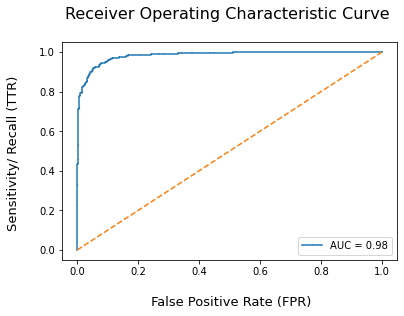

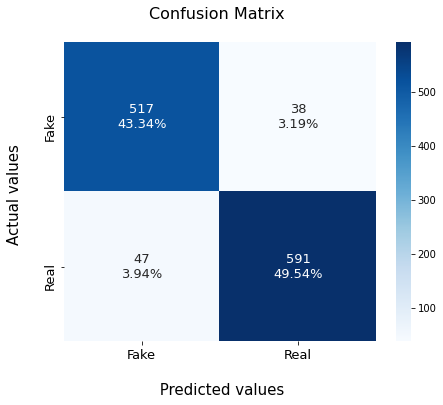

NameError: name 'tfvocab' is not defined

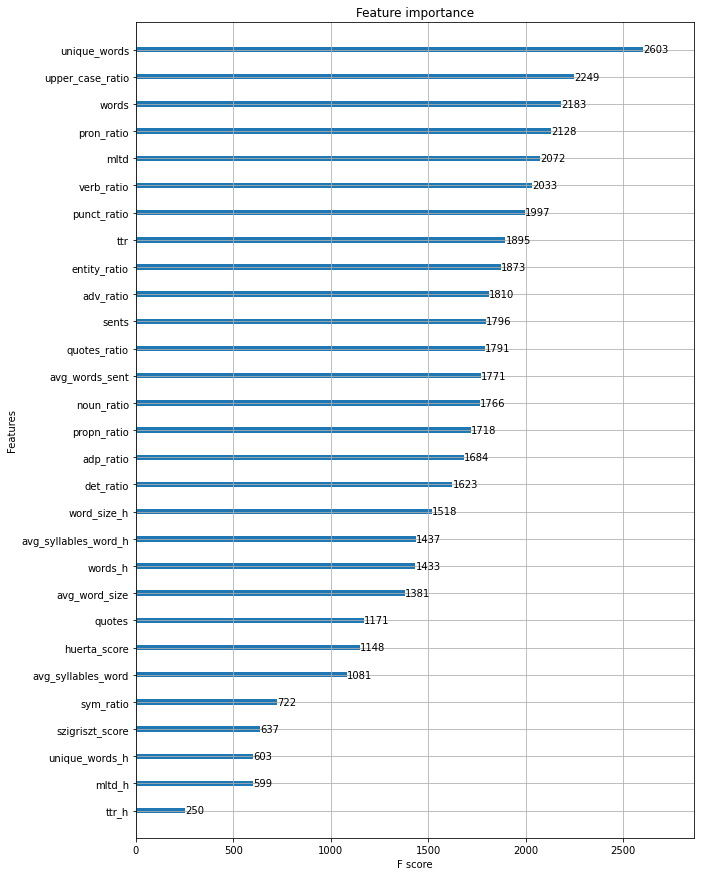

In [168]:
%%time

import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from scipy import stats
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, log_loss, f1_score

df = pd.read_csv('../data/spanish_corpus_features_v6.csv')
y = df['label']

########### Training and testing split ########### 

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents', 'words',
                    'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score', 'upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio', 'propn_ratio', 
                    'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 'adv_ratio', 
                    'sym_ratio']

X = df[numeric_features]
feature_names = df[numeric_features].columns.tolist()

# Calculating level of imbalance for modelling
imbalance_weight = y.value_counts(normalize = True)[0] / y.value_counts(normalize = True)[1]

# Training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)


########### XGB CLassifier ########### 

xgb_model = XGBClassifier(eval_metric = 'auc', objective = 'binary:logistic', nthread = 1, seed = 43, 
                    scale_pos_weight = imbalance_weight)

xgb_params = {'learning_rate': [0.01],
              'n_estimators': [1000, 1200],
              'max_depth': [8, 10], 
              'subsample': [0.4], 
              'colsample_bytree': [0.75],
              'min_child_weight' : [0.5, 1],
              'lambda': [0, 1],
              'alpha': [0.1]}

skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 43)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = xgb_params, 
                                   scoring = 'roc_auc', n_jobs = -1, cv = skf.split(X_train, y_train), verbose = 2)

grid_search.fit(X_train, y_train)

print('Best hyperparameters:' , grid_search.best_params_)
xgb_model = grid_search.best_estimator_


########### Predictions and results ###########

# prediction and results
y_pred = xgb_model.predict(X_test)
probs = xgb_model.predict_proba(X_test)
probs = probs[:, 1]

xgb_accuracy_score, xgb_auc_score, xgb_f1_score = prediction_results(xgb_model, y_test, X_test, y_pred, probs)

# confusion matrix

plot_confusion_matrix(y_test, y_pred)


########### Feature importance ###########

# feature importance with default names

f, ax = plt.subplots(figsize = [10, 15])
axsub = xgb.plot_importance(xgb_model, ax = ax)

# get the original names back
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(tfvocab))
list_yticklabels = [Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]

# feature importance
plt.title("XGBOOST Feature Importance", fontsize = 15)
axsub.set_yticklabels(list_yticklabels)
plt.show()

## 3. First model predictor

### First step is to load the model

In [57]:
import pickle

model = pickle.load(open('../predictors/fake_news_predictorv2.pkl', 'rb'))
model

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=1, learning_rate=0.01,
              max_delta_step=0, max_depth=8, min_child_weight=0.5, missing=nan,
              monotone_constraints='()', n_estimators=1200, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0.100000001,
              reg_lambda=1, scale_pos_weight=0.9423264907135874, seed=43,
              subsample=0.4, tree_method='exact', validate_parameters=1, ...)

In [105]:
xgb_model

XGBClassifier(alpha=0.4, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', lambda=0.5, learning_rate=0.03,
              max_delta_step=0, max_depth=6, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=1, nthread=1,
              num_parallel_tree=1, random_state=43, reg_alpha=0.400000006,
              reg_lambda=0.5, scale_pos_weight=0.9775967413441956, seed=43,
              subsample=0.5, tree_method='exact', validate_parameters=1, ...)

In [127]:
pd.options.display.max_columns = None

In [128]:
df_features

,n_words_h,word_size_h,avg_syllables_word_h,unique_words_h,ttr_h,mltd_h,n_sents,n_words,avg_words_sents,word_size,avg_syllables_word,unique_words,ttr,huerta_score,szigriszt_score,mltd,upper_case_ratio,entity_ratio,n_quotes,quotes_ratio,propn_ratio,noun_ratio,pron_ratio,adp_ratio,det_ratio,punct_ratio,verb_ratio,adv_ratio,sym_ratio
0,19,5.53,2.53,78.95,89.47,50.54,28,994,35.5,4.78,1.95,37.12,46.38,53.63,49.99,87.84,3.2,8.25,2,0.2,12.37,16.9,1.71,16.9,12.78,8.25,8.25,2.31,0.0


### Prediction

We are going to use the spanish language at the strings showing the news classification.

In [219]:
from newspaper import Article

url = input('Insert url: ')

article = Article(url)
article.download()
article.parse()

df_features = get_news_features(article.title, article.text)

# df_features = get_news_features(text, headline)

model = pickle.load(open('../predictors/fake_news_predictorv3.pkl', 'rb'))

numeric_features = ['words_h', 'word_size_h', 'avg_syllables_word_h', 'unique_words_h', 'ttr_h', 'mltd_h', 'sents',
                    'words', 'avg_words_sent', 'avg_word_size', 'avg_syllables_word', 'unique_words', 'ttr', 'mltd', 
                    'huerta_score', 'szigriszt_score','upper_case_ratio', 'entity_ratio', 'quotes', 'quotes_ratio',
                    'propn_ratio', 'noun_ratio', 'adp_ratio', 'det_ratio', 'punct_ratio', 'pron_ratio', 'verb_ratio', 
                    'adv_ratio', 'sym_ratio']

X_predict = df_features[numeric_features]

prob_fake = (model.predict_proba(X_predict)[0][0])*100
prob_real = (model.predict_proba(X_predict)[0][1])*100

if prob_fake >= 65:
    print('Esta noticia es falsa.\nCon una probabilidad del %.0f%%' % prob_fake)

elif (65 >= prob_fake >= 35):
    print('Esta noticia es engañosa o una opinión. \nTiene una probabilidad de %.0f%% de ser verdadera' % prob_real)
else:
    print('Esta noticia es verdadera.\nCon una probabilidad del %.0f%%' % prob_real)

Insert url: https://okdiario.com/opinion/ademas-delincuente-eres-desahogado-pablo-iglesias-6106553
Esta noticia es engañosa o una opinión. 
Tiene una probabilidad de 57% de ser verdadera


Now lets move all this to __[streamlit configuration](https://github.com/pipe11/TFM_fake_news_detector/blob/master/predictors/Streamlit_configuration.ipynb)__.